**Task 2: Exploratory Data Analysis**

This notebook presents an exploratory data analysis of customer churn data for an energy company. 

# 1. <a id='toc1_'></a>[Objectives:](#toc0_)
- To get some initial insights on the client's business in the form of key values and visualization of the data
- To investigate whether price sensitivity is the most influential factor for a customer churning.

----
# 2. <a id='toc2_'></a>[Import packages](#toc0_)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

from IPython.display import HTML
import base64
from io import BytesIO
from statsmodels.graphics.mosaicplot import mosaic
from collections import defaultdict

from utils import plot_prob_progression, plot_prob_contour_map
from data_summary import create_summary_table

from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform


# Shows plots in jupyter notebook
%matplotlib inline
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Set plot style
sns.set(color_codes=True)

---

# 3. <a id='toc3_'></a>[Data Collection and Preprocessing](#toc0_)

## 3.1. <a id='toc3_1_'></a>[Data Loading](#toc0_)

The analysis uses two datasets:
1. `client_data.csv`: Contains information about individual customers
2. `price_data.csv`: Includes pricing information

In [2]:
client_df = pd.read_csv('./data/client_data.csv')
price_df = pd.read_csv('./data/price_data.csv')
merged_df = pd.merge(client_df, price_df, on='id')

In [5]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


In [6]:
price_df.head(3)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0


---

## 3.2. <a id='toc3_2_'></a>[Data Profiling](#toc0_)


To get a comprehensive understanding of our dataset, we'll use a custom function `create_summary_table` from the `data_summary` module. This function provides a detailed summary of each variable in our dataset, including statistics, frequency distributions, and visualizations.


### 3.2.1. <a id='toc3_2_1_'></a>[Client data profile](#toc0_)

#### 3.2.1.1. <a id='toc3_2_1_1_'></a>[Client Data Profile Summary Table](#toc0_)

In [7]:
client_df.shape

(14606, 26)

No,Variable,Stats / Values,Freqs (% of Valid),Graph,Missing
1,id[object],563dde550fd624d7352f3de77c0cdfcd: 1 (0.0%)24011ae4ebbe3035111d65fa7c15bc57: 1 (0.0%)d29c2c54acc38ff3c0614d0a653813dd: 1 (0.0%)764c75f661154dac3a6c254cd082ea7d: 1 (0.0%)bba03439a292a1e166f80264c16191cb: 1 (0.0%),1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%),,0 (0.0%)
2,channel_sales[object],foosdfpfkusacimwkcsosbicdxkicaua: 6754 (46.2%)MISSING: 3725 (25.5%)lmkebamcaaclubfxadlmueccxoimlema: 1843 (12.6%)usilxuppasemubllopkaafesmlibmsdf: 1375 (9.4%)ewpakwlliwisiwduibdlfmalxowmwpci: 893 (6.1%),6754 (46.2%)3725 (25.5%)1843 (12.6%)1375 (9.4%)893 (6.1%),,0 (0.0%)
3,cons_12m[int64],Mean (sd): 159220.3 (573465.3)min < med < max: 0.0 < 14115.5 < 6207104.0IQR (CV): 35089.0 (3.6),11065 distinct values,,0 (0.0%)
4,cons_gas_12m[int64],Mean (sd): 28092.4 (162973.1)min < med < max: 0.0 < 0.0 < 4154590.0IQR (CV): 0.0 (5.8),2112 distinct values,,0 (0.0%)
5,cons_last_month[int64],Mean (sd): 16090.3 (64364.2)min < med < max: 0.0 < 792.5 < 771203.0IQR (CV): 3383.0 (4.0),4751 distinct values,,0 (0.0%)
6,date_activ[object],2009-08-01: 95 (0.7%)2010-02-01: 92 (0.6%)2009-09-01: 76 (0.5%)2009-10-01: 55 (0.4%)2010-01-11: 48 (0.3%),95 (0.7%)92 (0.6%)76 (0.5%)55 (0.4%)48 (0.3%),,0 (0.0%)
7,date_end[object],2016-02-01: 145 (1.0%)2016-08-01: 125 (0.9%)2016-09-01: 117 (0.8%)2016-10-05: 115 (0.8%)2016-12-31: 104 (0.7%),145 (1.0%)125 (0.9%)117 (0.8%)115 (0.8%)104 (0.7%),,0 (0.0%)
8,date_modif_prod[object],2015-11-01: 721 (4.9%)2015-05-24: 269 (1.8%)2015-12-17: 199 (1.4%)2015-09-20: 173 (1.2%)2015-12-16: 172 (1.2%),721 (4.9%)269 (1.8%)199 (1.4%)173 (1.2%)172 (1.2%),,0 (0.0%)
9,date_renewal[object],2015-06-23: 587 (4.0%)2015-03-09: 451 (3.1%)2015-02-09: 273 (1.9%)2015-07-04: 265 (1.8%)2015-10-11: 231 (1.6%),587 (4.0%)451 (3.1%)273 (1.9%)265 (1.8%)231 (1.6%),,0 (0.0%)
10,forecast_cons_12m[float64],Mean (sd): 1868.6 (2387.6)min < med < max: 0.0 < 1112.9 < 82902.8IQR (CV): 1906.8 (1.3),13993 distinct values,,0 (0.0%)

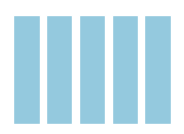
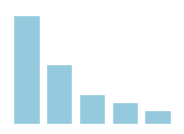
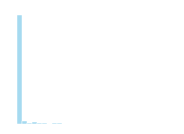
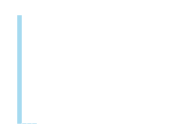
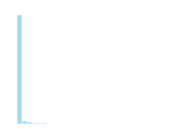
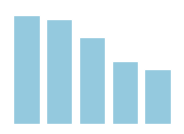
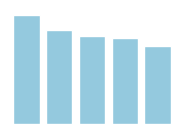
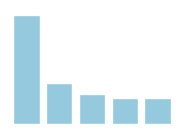
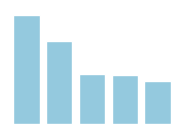
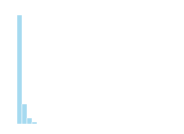
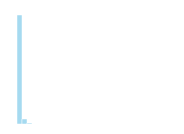
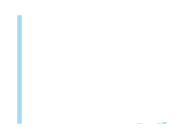
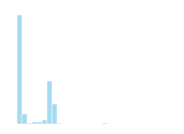
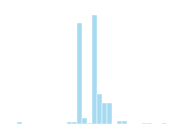
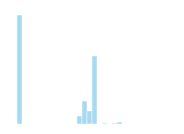
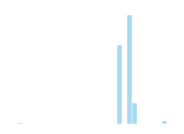
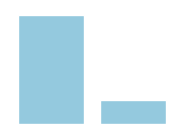
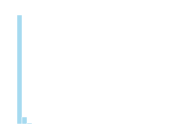
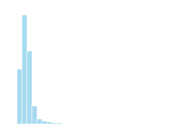
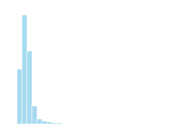
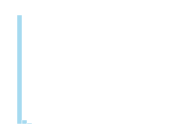
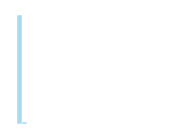
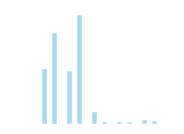
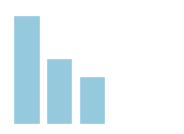
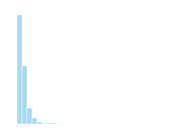
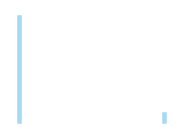

In [8]:
client_df_summary_table = create_summary_table(client_df)
display(client_df_summary_table)

#### 3.2.1.2. <a id='toc3_2_1_2_'></a>[Key Observations and Actions from Client Data](#toc0_)

1. **Missing Values:**
   - **Observation:** Most variables have no missing data, but `channel_sales` (25.5%) and `origin_up` (0.4%) have missing values.
   - **Action:** Handle missing data by imputing values (e.g., mode for `origin_up`) or creating a separate category for missing `channel_sales` during EDA.

2. **Churn Imbalance:**
   - **Observation:** The `churn` variable is imbalanced, with a 10% churn rate.
   - **Action:** Visualize churn distribution and consider balancing techniques (e.g., stratified sampling) in subsequent modeling steps.

3. **Customer Tenure:**
   - **Observation:** `num_years_antig` (customer tenure) spans from 1 to 13 years.
   - **Action:** Analyze tenure distribution and segment customers based on tenure for detailed churn analysis.

4. **Consumption Data Range:**
   - **Observation:** Consumption variables exhibit a wide range, suggesting potential outliers.
   - **Action:** Visualize the data distribution (e.g., boxplots) to identify and address outliers.

5. **Identical Forecast Variables:**
   - **Observation:** `forecast_cons_12m` and `forecast_cons_year` are identical.
   - **Action:** Drop one of these variables to simplify analysis.

6. **Discount and Energy Price Correlation:**
   - **Observation:** Negative correlation between `forecast_discount_energy` and `forecast_price_energy_peak`.
   - **Action:** Explore this relationship further to understand its implications for energy pricing trends.

7. **Off-Peak Price Correlation:**
   - **Observation:** Positive correlation between `forecast_price_energy_off_peak` and `forecast_price_pow_off_peak`.
   - **Action:** Visualize and decide whether to drop one variable or create interaction terms if necessary.

8. **Outliers in Numerical Variables:**
   - **Observation:** Numerical variables display potential outliers.
   - **Action:** Detect outliers through visualization and consider transformation techniques like logarithmic scaling to mitigate their impact on analysis.

9. **Time Variable Formatting:**
   - **Observation:** Date-related variables are stored as object types.
   - **Action:** Convert these variables to datetime format for accurate time-based analysis and trend exploration.
   
10. **Low Frequency Values:**
   - **Observation**: There is an indication of the presence of low frequency values in the `sales_channels` and `num_years_antig`.
   - **Action**: 
      - For `sales_channel`, group the low frequency values into a single category called "OTHER".
      - For `num_years_antig`, group the low frequency values by quantiles.


In [9]:
def save_summary_table_to_html(summary_table, file_path='./summary_table.html'):
    html_content = summary_table.data

    # Save the HTML content to a file
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(html_content)

    print(f"HTML file saved successfully at {file_path}.")

In [10]:
save_summary_table_to_html(client_df_summary_table, './images/client_df_summary_table.html')

HTML file saved successfully at ./images/client_df_summary_table.html.


### 3.2.2. <a id='toc3_2_2_'></a>[Price Data profile](#toc0_)

#### 3.2.2.1. <a id='toc3_2_2_1_'></a>[Price Data Profile Summary Table](#toc0_)

No,Variable,Stats / Values,Freqs (% of Valid),Graph,Missing
1,id[object],c18b6305122e4976739b8420d5b54ec5: 12 (0.0%)e4053a0ad6c55e4665e8e9adb9f75db5: 12 (0.0%)1221993f581c1b335d231e247028d40d: 12 (0.0%)2dc2c9a9f6e6896d9a07d7bcbb9d0ce9: 12 (0.0%)762cab733464cae4ce1d452ce84cb94b: 12 (0.0%),12 (0.0%)12 (0.0%)12 (0.0%)12 (0.0%)12 (0.0%),,0 (0.0%)
2,price_date[object],2015-12-01: 16094 (8.3%)2015-08-01: 16094 (8.3%)2015-07-01: 16090 (8.3%)2015-11-01: 16087 (8.3%)2015-10-01: 16085 (8.3%),16094 (8.3%)16094 (8.3%)16090 (8.3%)16087 (8.3%)16085 (8.3%),,0 (0.0%)
3,price_off_peak_var[float64],Mean (sd): 0.1 (0.0)min < med < max: 0.0 < 0.1 < 0.3IQR (CV): 0.0 (0.2),1853 distinct values,,0 (0.0%)
4,price_peak_var[float64],Mean (sd): 0.1 (0.0)min < med < max: 0.0 < 0.1 < 0.2IQR (CV): 0.1 (0.9),1189 distinct values,,0 (0.0%)
5,price_mid_peak_var[float64],Mean (sd): 0.0 (0.0)min < med < max: 0.0 < 0.0 < 0.1IQR (CV): 0.1 (1.2),711 distinct values,,0 (0.0%)
6,price_off_peak_fix[float64],Mean (sd): 43.3 (5.4)min < med < max: 0.0 < 44.3 < 59.4IQR (CV): 3.7 (0.1),66 distinct values,,0 (0.0%)
7,price_peak_fix[float64],Mean (sd): 10.6 (12.8)min < med < max: 0.0 < 0.0 < 36.5IQR (CV): 24.3 (1.2),31 distinct values,,0 (0.0%)
8,price_mid_peak_fix[float64],Mean (sd): 6.4 (7.8)min < med < max: 0.0 < 0.0 < 17.5IQR (CV): 16.2 (1.2),28 distinct values,,0 (0.0%)

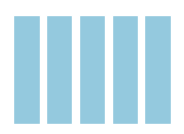
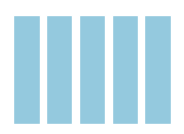
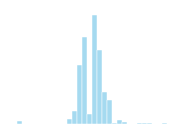
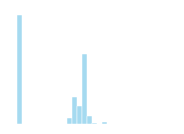
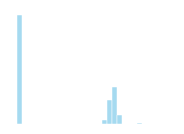
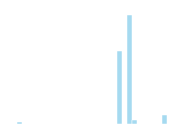
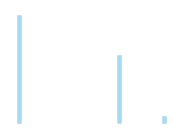
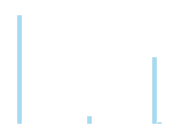

In [11]:
price_df_summary_table = create_summary_table(price_df)
display(price_df_summary_table)

In [32]:
# Calculate the number of rows with zero values for each price variable
zero_price_rows = price_df[price_df['price_off_peak_var'] == 0].shape[0]
print(f"Number of rows with zero values for 'price_off_peak_var': {zero_price_rows}")

zero_price_rows = price_df[price_df['price_peak_var'] == 0].shape[0]
print(f"Number of rows with zero values for 'price_peak_var': {zero_price_rows}")

zero_price_rows = price_df[price_df['price_mid_peak_var'] == 0].shape[0]
print(f"Number of rows with zero values for 'price_mid_peak_var': {zero_price_rows}")

zero_price_rows = price_df[price_df['price_off_peak_fix'] == 0].shape[0]
print(f"Number of rows with zero values for 'price_off_peak_fix': {zero_price_rows}")

zero_price_rows = price_df[price_df['price_peak_fix'] == 0].shape[0]
print(f"Number of rows with zero values for 'price_peak_fix': {zero_price_rows}")

zero_price_rows = price_df[price_df['price_mid_peak_fix'] == 0].shape[0]
print(f"Number of rows with zero values for 'price_mid_peak_fix': {zero_price_rows}")


Number of rows with zero values for 'price_off_peak_var': 346
Number of rows with zero values for 'price_peak_var': 86802
Number of rows with zero values for 'price_mid_peak_var': 112834
Number of rows with zero values for 'price_off_peak_fix': 1490
Number of rows with zero values for 'price_peak_fix': 112998
Number of rows with zero values for 'price_mid_peak_fix': 112996


#### 3.2.2.2. <a id='toc3_2_2_2_'></a>[Key Observations and Actions from Price Data](#toc0_)

1. **Missing Values:**
   - **Observation:** No missing values.
   - **Action:** No data cleaning required for missing values.

2. **Low Price Variability:**
   - **Observation:** 'price_off_peak_var', 'price_peak_var', and 'price_mid_peak_var' show low variability, indicating consistent pricing.
   - **Action:** Retain these variables but be cautious when interpreting results due to their low variation.

3. **Fixed Price Variation:**
   - **Observation:** 'price_off_peak_fix', 'price_peak_fix', and 'price_mid_peak_fix' exhibit more variation.
   - **Action:** Visualize the distribution of fixed prices and assess potential outliers.

3. **Zero-Values:**
   - **Observation:** price related features contain many zero values.
   - **Action:** Carefully analyze the result when aggregating these features into client-level data.

4. **Time Variable Formatting:**
   - **Observation:** 'price_date' is an object type.
   - **Action:** Convert 'price_date' to datetime format for proper time-based analysis and trend exploration.

In [12]:
save_summary_table_to_html(price_df_summary_table, './images/price_df_summary_table.html')

HTML file saved successfully at ./images/price_df_summary_table.html.


## 3.3. <a id='toc3_3_'></a>[Data Preprocessing and Cleaning](#toc0_)

In [3]:
client_df_processed = client_df.copy(deep=True)

### 3.3.1. <a id='toc3_3_1_'></a>[Adjusting the data type of date related variables](#toc0_)


In [4]:
def convert_dates(df, date_columns):
    for column in date_columns:
        df[column] = pd.to_datetime(df[column])
    return df

# Convert date related variables to datetime data type for client_df
client_df_processed = convert_dates(client_df, ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])

# Convert date related variables to datetime data type for price_df
price_df = convert_dates(price_df, ['price_date'])

### 3.3.2. <a id='toc3_3_2_'></a>[Simplify channel_sales values](#toc0_)


In [5]:
# Simplify channel_sales values excluding "MISSING"
channel_sales_mapping = {channel: f'Channel_{i}' for i, channel in enumerate(client_df_processed[client_df_processed['channel_sales'] != 'MISSING']['channel_sales'].unique())}
client_df_processed['channel_sales'] = client_df_processed['channel_sales'].map(channel_sales_mapping)

### 3.3.3. <a id='toc3_3_3_'></a>[Missing Values](#toc0_)

#### 3.3.3.1. <a id='toc3_3_3_1_'></a>[Investigating Missing Values](#toc0_)

In previous section, we already learned that channel_sales and origin_up have missing values. Now, let's see if there is a relationship between missing values in channel_sales and churn.


Let's conduct a chi-square test to determine if there is relationship between missing values in channel_sales and churn. 
- null hypothesis (H0): that there is no association between missing values in the channel_sales variable and the churn outcome. 
- alternative hypothesis (H1): that there is a significant association. 
- A p-value less than the significance level (typically 0.05) will lead us to reject the null hypothesis, indicating a potential impact of missing values on churn.

Additionally, we will calculate Cramer's V to assess the strength of the association:
- Cramer's V ranges from 0 to 1, where values closer to 0 indicate a weak association and values closer to 1 indicate a strong association.


In [106]:
def analyze_missing_values_impact(df, column_name):
    # Create a contingency table
    contingency_table = pd.crosstab(df[column_name].isnull(), df['churn'])
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print("Chi-square test results:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print(f"There is a significant relationship between missing values in {column_name} and churn.")
    else:
        print(f"There is no significant relationship between missing values in {column_name} and churn.")

    n = contingency_table.sum().sum()
    min_dim = max(min(contingency_table.shape) - 1, 1)  # Ensure min_dim is at least 1
    cramer_v = np.sqrt(chi2 / (n * min_dim)) 

    print(f"\nEffect size (Cramer's V): {cramer_v:.4f}")

    # Interpret effect size
    if cramer_v < 0.1:
        effect_size = "negligible"
    elif cramer_v < 0.3:
        effect_size = "small"
    elif cramer_v < 0.5:
        effect_size = "medium"
    else:
        effect_size = "large"

    print(f"The effect size is {effect_size}.")
    # Conclusion
    print("\nConclusion:")
    if p_value < alpha:
        if cramer_v < 0.1:
            print(f"Although statistically significant, the relationship between missing values in {column_name} and churn is negligible in practical terms.")
        else:
            print(f"Removing missing values in {column_name} might significantly impact the churn analysis.")
    else:
        print(f"Removing missing values in {column_name} is unlikely to significantly impact the churn analysis.")

In [107]:
# Apply the function on channel_sales and origin_up
analyze_missing_values_impact(client_df_processed, 'channel_sales')

Chi-square test results:
Chi-square statistic: 25.2464
p-value: 0.0000
There is a significant relationship between missing values in channel_sales and churn.

Effect size (Cramer's V): 0.0416
The effect size is negligible.

Conclusion:
Although statistically significant, the relationship between missing values in channel_sales and churn is negligible in practical terms.


In [108]:
analyze_missing_values_impact(client_df_processed, 'origin_up')

Chi-square test results:
Chi-square statistic: 0.0000
p-value: 1.0000
There is no significant relationship between missing values in origin_up and churn.

Effect size (Cramer's V): 0.0000
The effect size is negligible.

Conclusion:
Removing missing values in origin_up is unlikely to significantly impact the churn analysis.


**Summary**

**Channel Sales**:
- **Interpretation**: The relationship between channel_sales and churn is statistically detectable, but practically insignificant: There's a tiny, measurable connection between missing 'channel_sales' data and churn. However, this connection is so weak that it won't affect our ability to understand or predict churn.
- **Implication for handling missing data**: We can likely fill in these missing 'channel_sales' values using a simple method (like the most frequent category or an 'Unknown' category) without skewing our churn analysis.

**Origin Up**:
- **Interpretation**: Missing data in the 'origin_up' field has no relationship with whether a customer churns.
- **Implication for handling missing data**: We can safely ignore the missing 'origin_up' data points or use a simple imputation strategy, as they won't influence our churn insights.

#### 3.3.3.2. <a id='toc3_3_3_2_'></a>[Handling Missing Values](#toc0_)


In [6]:
# Decide on handling strategy based on analysis
# fill missing values with a placeholder
client_df_processed['channel_sales'] = client_df_processed['channel_sales'].fillna('Unknown')
client_df_processed['origin_up'] = client_df_processed['origin_up'].fillna('Unknown')

print("\nMissing values after handling:")
print(client_df_processed[['channel_sales', 'origin_up']].isnull().sum())


Missing values after handling:
channel_sales    0
origin_up        0
dtype: int64


### 3.3.4. <a id='toc3_3_4_'></a>[Handling Sparse Variables](#toc0_)

#### 3.3.4.1. <a id='toc3_3_4_1_'></a>[Grouping Low-Frequency Sales Channels](#toc0_)


On the summary table, there is an indication of the presence of low frequency sales channels. Let's investigate this further. Below is the value counts of the channel_sales variable:

In [110]:
client_df_processed['channel_sales'].value_counts()

channel_sales
Channel_0    6754
Unknown      3725
Channel_1    1843
Channel_2    1375
Channel_3     893
Channel_5      11
Channel_4       3
Channel_6       2
Name: count, dtype: int64

The above table shows that there are 6 sales channels with less than 11 customers. Let's group these low-frequency sales channels into a single category called "OTHER".

In [7]:
def categorize_low_counts(df, column_name, threshold=11, other_label='OTHER'):
    """Categorizes values in a DataFrame column with counts below a threshold.

    Args:
        df (pd.DataFrame): The DataFrame to work with.
        column_name (str): The name of the column to categorize.
        threshold (int, optional): Count threshold for grouping. Defaults to 11.
        other_label (str, optional): Label to use for grouped values. Defaults to 'OTHER'.

    Returns:
        pd.Series: A Series representing the categorized column.
    """

    value_counts = df[column_name].value_counts()
    common_values = value_counts[value_counts > threshold].index
    df[column_name] = df[column_name].where(df[column_name].isin(common_values), other_label)
    return df[column_name]

In [8]:
client_df_processed['channel_sales'] = categorize_low_counts(client_df_processed, 'channel_sales', threshold=11)
client_df_processed['channel_sales'].value_counts()

channel_sales
Channel_0    6754
Unknown      3725
Channel_1    1843
Channel_2    1375
Channel_3     893
OTHER          16
Name: count, dtype: int64

#### 3.3.4.2. <a id='toc3_3_4_2_'></a>[Grouping Client Antiquity by Quantiles](#toc0_)

The distribution of 'num_years_antig' is characterized by sparsity, where certain values occur significantly less frequently than others. This can lead to challenges in analysis and modeling, as low-frequency categories may not provide enough data for reliable insights. 

To address this issue, we will group the values into quantiles. This approach allows us to create a more balanced representation of the data, ensuring that each group contains a sufficient number of observations. By doing so, we can enhance the robustness of our analysis and improve the interpretability of the results.

In [9]:
client_df_processed['num_years_antig_grp'] = pd.qcut(client_df_processed['num_years_antig'], q=4, labels=None)

In [10]:
client_df_processed['num_years_antig_grp'].value_counts()

num_years_antig_grp
(0.999, 4.0]    6427
(5.0, 6.0]      4769
(4.0, 5.0]      2317
(6.0, 13.0]     1093
Name: count, dtype: int64

### 3.3.5. <a id='toc3_3_5_'></a>[Outliers](#toc0_)

#### 3.3.5.1. <a id='toc3_3_5_1_'></a>[Investigating outliers frequency and their impact on churn](#toc0_)

In this section, we conduct a comprehensive analysis of outliers in our dataset and their potential impact on customer churn. Outliers, being extreme values that deviate significantly from other observations, can sometimes provide valuable insights into customer behavior or indicate data quality issues that need addressing.

Our analysis focuses on two key aspects:

1. The prevalence of outliers in each feature, quantified as a percentage of the total observations.
2. The difference in churn rates between outliers and non-outliers for each feature.

By examining these aspects, we aim to:
- Identify which features are most prone to outliers
- Understand how outliers in different features correlate with customer churn
- Prioritize our data cleaning and feature engineering efforts based on the impact of outliers on churn prediction



These insights will guide our subsequent steps in data preprocessing and model development, ensuring we focus our efforts on the most impactful features for predicting and preventing customer churn.

In [11]:
# Define numerical columns for outlier analysis
numerical_columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 
                     'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max']

# Function to calculate IQR and identify outliers
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_results = []

# Analyze outliers for each numerical column
for column in numerical_columns:
    outliers, lower_bound, upper_bound = identify_outliers(client_df_processed, column)
    
    # Analyze relationship between outliers and churn
    outlier_churn_rate = outliers['churn'].mean()
    overall_churn_rate = client_df_processed['churn'].mean()
    

    # Append the results to the list
    outlier_results.append({
        'Feature': column,
        'Num_Outliers': len(outliers),
        'Pct_Outliers': (len(outliers) / len(client_df_processed)) * 100,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Min_Value': client_df_processed[column].min(),
        'Max_Value': client_df_processed[column].max(),
        'Outlier_Churn_Rate': outlier_churn_rate,
        'Overall_Churn_Rate': overall_churn_rate,
        'Churn_Rate_Difference': abs(outlier_churn_rate - overall_churn_rate)
    })

outlier_result_df = pd.DataFrame(outlier_results)

In [94]:
outlier_result_df

,Feature,Num_Outliers,Pct_Outliers,Lower_Bound,Upper_Bound,Min_Value,Max_Value,Outlier_Churn_Rate,Overall_Churn_Rate,Churn_Rate_Difference
0,cons_12m,2084,14.268109,-46958.75000,93397.25000,0.0,6207104.00,0.080614,0.097152,0.016538
1,cons_gas_12m,2612,17.883062,0.00000,0.00000,0.0,4154590.00,0.084609,0.097152,0.012542
2,cons_last_month,2051,14.042174,-5074.50000,8457.50000,0.0,771203.00,0.076548,0.097152,0.020604
3,forecast_cons_12m,1054,7.216213,-2365.19750,5261.98250,0.0,82902.83,0.105313,0.097152,0.008161
4,imp_cons,1215,8.318499,-290.97000,484.95000,0.0,15042.79,0.099588,0.097152,0.002437
5,margin_gross_pow_ele,660,4.518691,-9.12000,53.28000,0.0,374.64,0.183333,0.097152,0.086181
6,margin_net_pow_ele,660,4.518691,-9.12000,53.28000,0.0,374.64,0.183333,0.097152,0.086181
7,net_margin,1022,6.997124,-237.86500,531.67500,0.0,24570.65,0.125245,0.097152,0.028093
8,pow_max,1535,10.509380,2.49125,29.18125,3.3,320.00,0.115961,0.097152,0.018809


The following visualizations provide a clear picture of our findings:
- The first plot shows the percentage of outliers for each feature, helping us identify which variables are most affected by extreme values.
- The second plot illustrates the difference in churn rates between outliers and non-outliers for each feature, indicating which outliers have the most significant impact on customer churn.

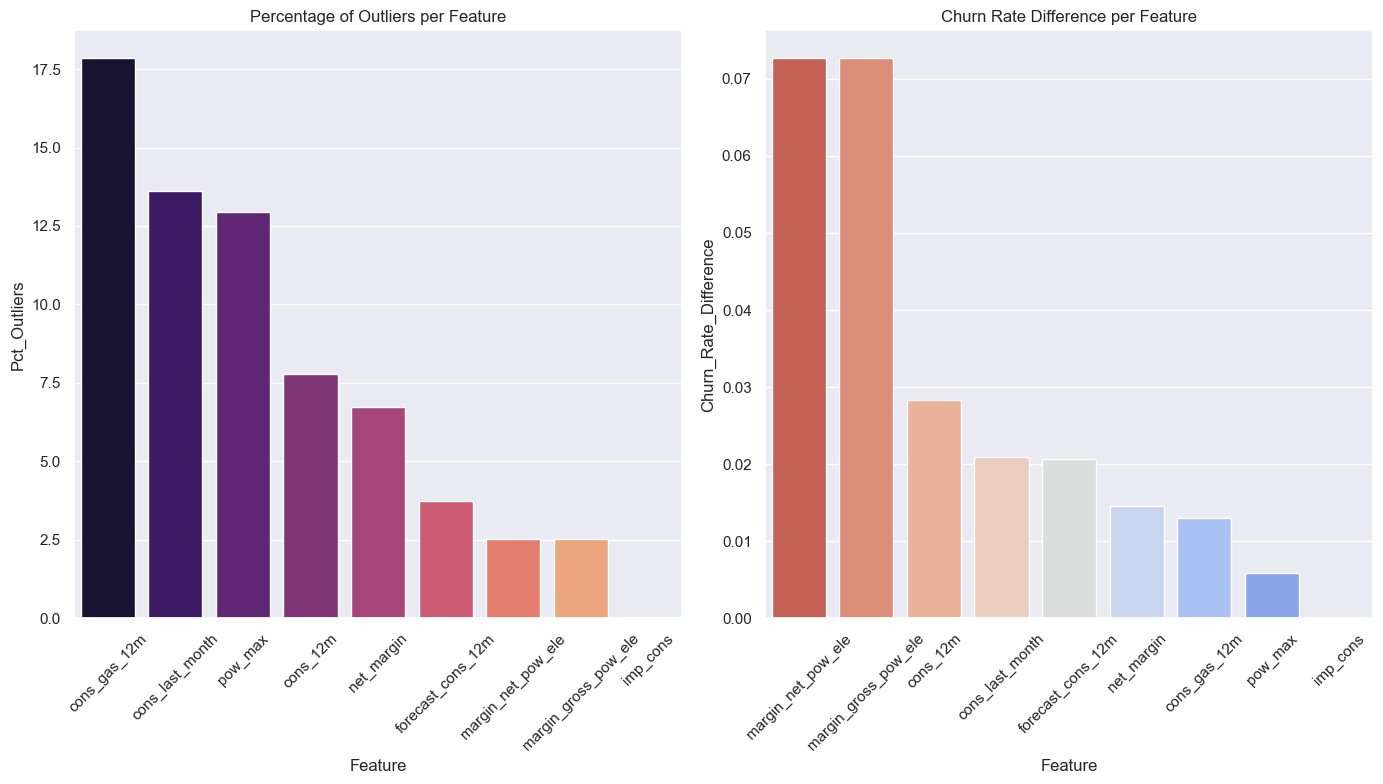

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot 1: Percentage of Outliers per Feature
sns.barplot(x='Feature', y='Pct_Outliers', 
            data=outlier_result_df.sort_values('Pct_Outliers', ascending=False), 
            hue='Feature', palette='magma', ax=axes[0], legend=False)
axes[0].set_title('Percentage of Outliers per Feature')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Churn Rate Difference per Feature
sns.barplot(x='Feature', y='Churn_Rate_Difference', 
            data=outlier_result_df.sort_values('Churn_Rate_Difference', ascending=False), 
            hue='Feature', palette='coolwarm_r', ax=axes[1], legend=False)
axes[1].set_title('Churn Rate Difference per Feature')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The above visualization highlights key features where outliers significantly affect churn rates.

**Highlights**: 
1. **High Impact on Churn:**
   - **Features:** `margin_net_pow_ele` and `margin_gross_pow_ele`
   - **Context:** This implies that extreme values in these features significantly influence customer behavior.
   - **Action:** Prioritize cleaning these features by removing the outlier.

2. **Moderate Impact:**
   - **Features:** `net_margin` and `cons_last_month`
   - **Context:** This suggest that extreme financial and recent consumption behaviors are linked to higher churn although the impact is moderate
   - **Action:** Address outliers here to refine retention strategies, focusing on customers facing recent financial or consumption challenges.

3. **Lower Impact:**
   - **Features:** `cons_12m`, `cons_gas_12m`, `forecast_cons_12m`, `imp_cons`
   - **Context:** While outliers in these features may impact churn, the effect is less pronounced.
   - **Action:** Basic outlier treatment is sufficient; prioritize more impactful features for deeper cleaning.



#### 3.3.5.2. <a id='toc3_3_5_2_'></a>[Treating Outliers](#toc0_)

1. For high-impact features (margin_net_pow_ele, margin_gross_pow_ele, net_margin), we remove extreme outliers to significantly reduce their influence on churn prediction.
2. For cons_last_month, which has a moderate impact, we cap the outliers at the 1st and 99th percentiles.
3. For lower-impact consumption-related features (cons_12m, cons_gas_12m, forecast_cons_12m, imp_cons), we apply a log transformation. This helps to reduce the impact of outliers while preserving more of the original data distribution.

In [12]:
def treat_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99, method='cap'):
    lower = df[column].quantile(lower_percentile)
    upper = df[column].quantile(upper_percentile)
    
    if method == 'remove':
        df = df[(df[column] >= lower) & (df[column] <= upper)]
    elif method == 'cap':
        df.loc[df[column] < lower, column] = lower
        df.loc[df[column] > upper, column] = upper
    elif method == 'log':
        df[column] = np.log1p(df[column] - min(0, df[column].min()) + 1)
    
    return df

# Define treatment strategy for each column
treatment_strategy = {
    'margin_net_pow_ele': 'remove',
    'margin_gross_pow_ele': 'remove',
    'net_margin': 'remove',
    'cons_last_month': 'cap',
    'cons_12m': 'log',
    'cons_gas_12m': 'log',
    'forecast_cons_12m': 'log',
    'imp_cons': 'log'
}

# Treat outliers for each column
for column, method in treatment_strategy.items():
    client_df_processed = treat_outliers(client_df_processed, column, method=method)

# For other numeric columns not specified, apply a basic cap
other_numeric_columns = ['forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m',
                         'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
                         'forecast_price_pow_off_peak', 'num_years_antig', 'pow_max']

for column in other_numeric_columns:
    client_df_processed = treat_outliers(client_df_processed, column, method='cap')

print("Outlier treatment completed.")

Outlier treatment completed.


### 3.3.6. <a id='toc3_3_6_'></a>[Preparing Client-Level Price Sensitivity Features](#toc0_)

In [13]:
# Calculate average prices for each client
price_features = price_df.groupby('id').agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [14]:
# add price sensitivity features to the client data
client_df_processed = pd.merge(client_df_processed, price_features, on='id', how='left')

In [17]:
#sanity check the data shape after merging
client_df_processed.shape

(14171, 34)

---

# 4. <a id='toc4_'></a>[Exploratory Data analysis](#toc0_)


In [59]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

## 4.1. <a id='toc4_1_'></a>[Churn Distribution](#toc0_)

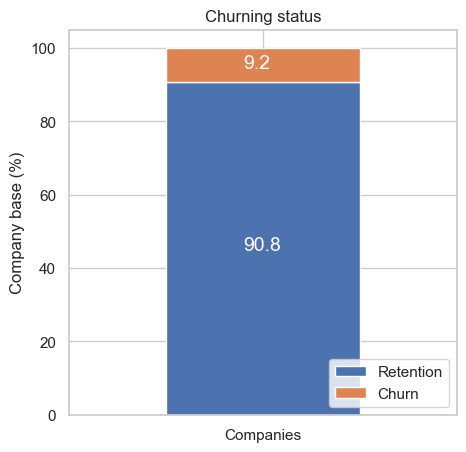

In [60]:
churn = client_df[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100
plot_stacked_bars(churn_percentage.transpose(), "Churning status", (5, 5), legend_="lower right")

In [58]:
churn_rate = client_df['churn'].mean()
print(f"Churn Rate: {churn_rate:.2%}")

Churn Rate: 9.24%


## 4.2. <a id='toc4_2_'></a>[Mapping Feature Correlations and Identifying Key Churn Indicators](#toc0_)

In this section, we explore the relationships between various features in our dataset and their impact on customer churn. The goal is to identify the most influential factors driving customer churn.

We present two key visualizations:
1. A correlation heatmap: This offers a comprehensive view of inter-feature relationships, helping identify patterns and potential multicollinearity issues.
2. A bar plot of feature-churn correlations: This highlights the strength and direction of each feature's association with churn, pinpointing the most significant predictors.


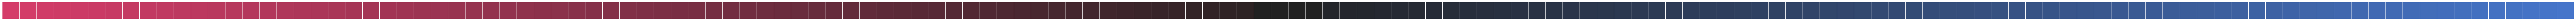

In [21]:
#defining color palette
sns.palplot(sns.diverging_palette(0, 255, sep=8, n=150, center='dark'))

main_facecolor = '#FFFFFF'
main_facecolor2 = '#0D0D0D'
cmap1 = sns.diverging_palette(230, 20, as_cmap=True)
cmap2 = ["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333", "#3c4e4b", "#466964", "#599e94", "#6cd4c5"]
cmap3 = sns.diverging_palette(0, 255, sep=1, n=50, center='dark')

In [18]:
def is_binary(series, unique_tol=2):
    return series.nunique() <= unique_tol

def mixed_corr(df):
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    
    for col1 in df.columns:
        for col2 in df.columns:
            try:
                if is_binary(df[col1]) and is_binary(df[col2]):
                    # Both are binary
                    corr_val = df[col1].corr(df[col2], method='pearson')
                elif is_binary(df[col1]) or is_binary(df[col2]):
                    # One is binary and the other is continuous
                    binary_col = col1 if is_binary(df[col1]) else col2
                    cont_col = col2 if is_binary(df[col1]) else col1
                    corr_val = pointbiserialr(df[cont_col], df[binary_col])[0]
                else:
                    # Both are continuous
                    corr_val = df[col1].corr(df[col2])
                
                corr_matrix.at[col1, col2] = corr_val
            except Exception as e:
                print(f"An error occurred while processing {col1} and {col2}: {e}")
    return corr_matrix

def enforce_symmetry(df):
    return (df + df.T)/2


def plot_heatmap(data, title, figsize=(16, 10)):
    mask = np.triu(np.ones_like(data, dtype=bool))
    fig, ax = plt.subplots(figsize=figsize, facecolor=main_facecolor)
    ax.set_facecolor('#f0f0f0')
    ax.grid(False)
    ax.set_title(title, fontsize=14, fontweight='semibold', fontfamily='sans-serif', color="#413f42",
                 bbox=dict(facecolor='#f0f0f0', edgecolor='#d5d3d6', boxstyle='round,pad=0.6', alpha=0.6))

    _ = sns.heatmap(data, cmap=cmap3, vmax=1, vmin=-1, center=0, square=True, annot=True, linewidths=.5,
                    linecolor='#f0f0f0', cbar_kws={"shrink": .5}, annot_kws={"size": 8}, fmt=".2f")

In [19]:
#creating clustered correlation matrix
df_numeric = client_df_processed.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])
mixed_corr_matrix = mixed_corr(df_numeric)

dissimilarity = 1 - abs(mixed_corr_matrix)

# Enforce symmetry
symmetric_dissimilarity = enforce_symmetry(dissimilarity)

# Set diagonal to zero
np.fill_diagonal(symmetric_dissimilarity.values, 0)

# Check for symmetry
print((symmetric_dissimilarity.T == symmetric_dissimilarity).all().all())

# Proceed with clustering
Z = linkage(squareform(symmetric_dissimilarity), 'ward')

#Clusterize the data
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(df_numeric.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df_numeric[i])
    else:
        df_to_append = pd.DataFrame(df_numeric[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

clustered_corr = clustered.corr()

True


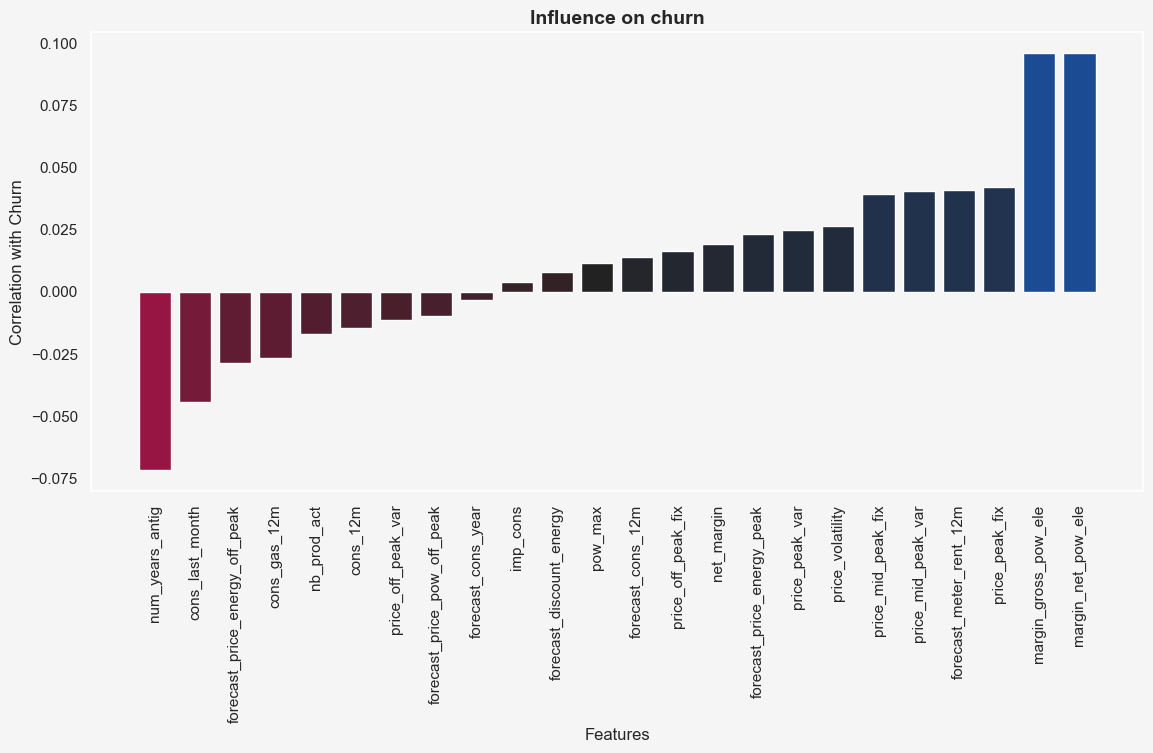

In [23]:
def plot_churn_correlation_bar(df, title, settings, horizontal=False):
    """
    Function to plot a bar chart showing correlations with churn.

    Parameters:
    df (pd.Series): DataFrame containing correlation values with churn.
    title (str): Title of the plot.
    settings (dict): Dictionary of settings for the plot.
    horizontal (bool): If True, plots a horizontal bar chart.
    """
    fig, ax = plt.subplots(figsize=settings.get('figsize', (6, 4)))
    
    # Create a diverging palette with red for negative values and blue for positive values
    cmap = sns.diverging_palette(h_neg=0, h_pos=255, s=90, l=33, sep=5, n=120, center='dark', as_cmap=True)
    
    ax.set_facecolor('whitesmoke')
    fig.set_facecolor('whitesmoke')
    
    values = df.values
    norm = plt.Normalize(values.min(), values.max())
    colors = cmap(norm(values))

    if not horizontal:
        ax.bar(df.index, df.values, color=colors, width=settings.get('width', 0.3))
        ax.set_xlabel(settings.get('x_label', ''), fontsize=settings.get('fontsize_axes_label', 14))
        ax.set_ylabel(settings.get('y_label', ''), fontsize=settings.get('fontsize_axes_label', 14))
    else:
        ax.barh(df.index, df.values, color=colors, height=settings.get('width', 0.3))
        ax.set_ylabel(settings.get('x_label', ''), fontsize=settings.get('fontsize_axes_label', 14))
        ax.set_xlabel(settings.get('y_label', ''), fontsize=settings.get('fontsize_axes_label', 14))

    ax.set_title(title, fontsize=settings.get('fontsize_title', 14), fontweight='bold')
    ax.grid(False)

    if horizontal:
        plt.yticks(rotation=settings.get('x_label_rotation', 0))
    else:
        plt.xticks(rotation=settings.get('x_label_rotation', 0))

    plt.tight_layout(pad=2)
    plt.show()

def create_churn_correlation_plot(df, title, horizontal=False, **kwargs):
    """
    Wrapper function to create a churn correlation bar chart with custom settings.

    Parameters:
    df (pd.Series): DataFrame containing correlation values with churn.
    title (str): Title of the plot.
    horizontal (bool): If True, plots a horizontal bar chart.
    **kwargs: Additional keyword arguments for settings.
    """
    bar_setting_dict = {
        'x_label': 'Features',
        'y_label': 'Correlation with Churn',
        'figsize': (12, 8),
        'width': 0.8,
        'x_label_rotation': 90,
        'fontsize_title': 14,
        'fontsize_axes_label': 12
    }

    bar_setting_dict.update(kwargs)
    plot_churn_correlation_bar(df, title, bar_setting_dict, horizontal=horizontal)

corr_pairs = clustered_corr.unstack().sort_values()
corr_churn= corr_pairs['churn']
corr_churn = corr_churn[corr_churn.index != 'churn']

create_churn_correlation_plot(corr_churn, title='Influence on churn', width=0.8, figsize=(12, 8), x_label_rotation=90, horizontal=False)

Highlights:

1. Strongest Positive Indicator:
   - margin_net_pow_ele and margin_gross_pow_ele both show the highest positive correlation with churn (0.096).
   - These two variables are almost perfectly correlated (0.999), effectively representing the same information.
   - For simplicity and to avoid redundancy, we'll focus on margin_net_pow_ele in further analyses.
   - The positive correlation suggests a slight tendency for higher margins to be associated with increased churn risk.

2. Strongest Negative Indicator:
   - num_years_antig shows the strongest negative correlation with churn (-0.072).
   - This indicates a slight tendency for longer-term customers to have lower churn rates.

3. Comparison of Key Indicators:
   - Both margin_net_pow_ele and num_years_antig have weak correlations with churn (|r| < 0.1).
   - The opposing directions of these correlations suggest potentially different dynamics in customer retention.

4. Overall Observation:
   - The weak correlations (max |r| ≈ 0.096) indicate that no single factor strongly predicts churn on its own or that the relationship with churn is non-linear.
   - This suggests that churn is likely influenced by a combination of factors rather than being determined by any single variable.

Key Takeaways:
1. margin_net_pow_ele emerges as the strongest positive indicator of churn, albeit with a weak correlation.
2. num_years_antig stands out as the strongest negative indicator of churn, also with a weak correlation.
3. The weakness of these correlations underscores the complex nature of churn prediction and the need for more in-depth analysis.

These findings provide a foundation for the subsequent sections, where we will conduct a deeper analysis of margin_net_pow_ele and num_years_antig to better understand their relationship with churn.

---

## 4.3. <a id='toc4_3_'></a>[Investigating Churn and Client Spending Relationship](#toc0_)

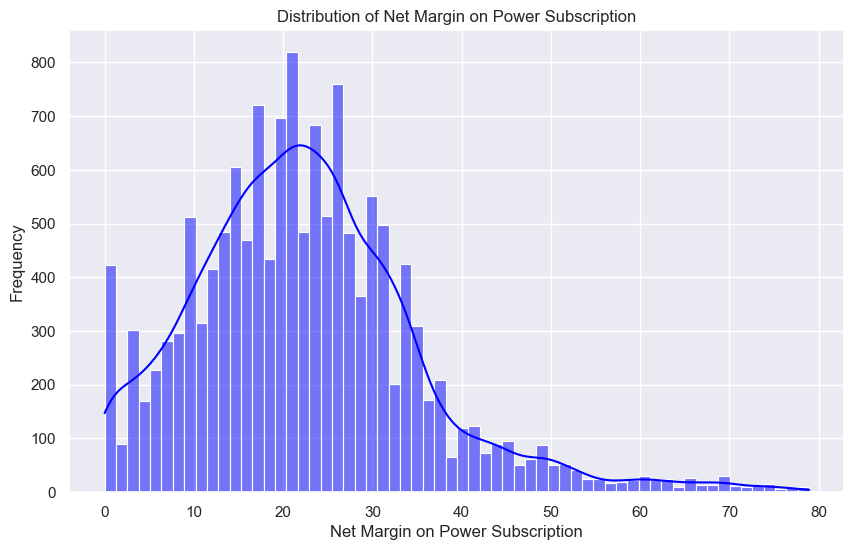

In [29]:
# Plotting the distribution of 'net_margin'
plt.figure(figsize=(10, 6))
sns.histplot(client_df['margin_net_pow_ele'], kde=True, color='blue')
plt.title('Distribution of Net Margin on Power Subscription')
plt.xlabel('Net Margin on Power Subscription')
plt.ylabel('Frequency')
plt.show()


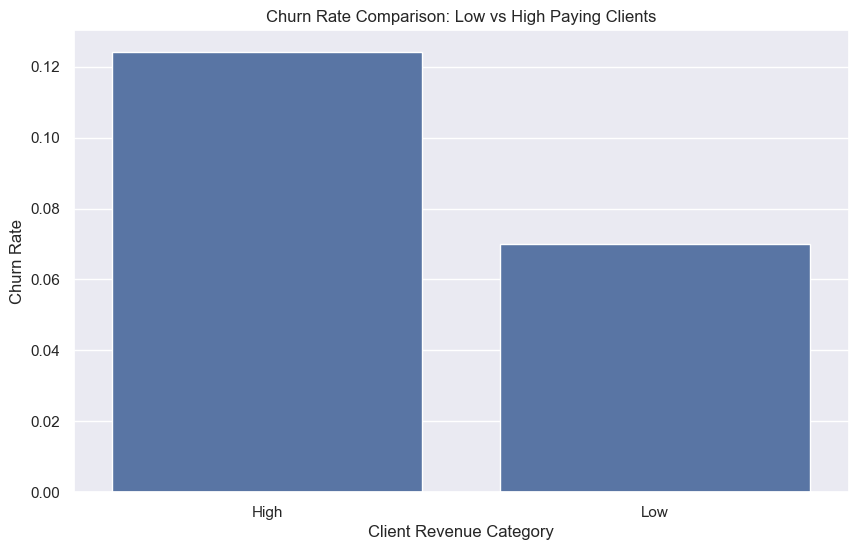


Chi-square statistic: 121.27724322150854
p-value: 3.322933289356477e-28


In [26]:
# Calculate median annual revenue
median_revenue = client_df['margin_net_pow_ele'].median()

# Categorize clients
client_df['powersubs_revenue_category'] = client_df['margin_net_pow_ele'].apply(lambda x: 'High' if x >= median_revenue else 'Low')

# Calculate churn rates
churn_rates = client_df.groupby('powersubs_revenue_category')['churn'].mean()

# # Calculate tenure for high vs low paying clients
# tenure_comparison = client_df.groupby('powersubs_revenue_category')['num_years_antig'].mean()

# Visualize churn rates
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.title('Churn Rate Comparison: Low vs High Paying Clients')
plt.xlabel('Client Revenue Category')
plt.ylabel('Churn Rate')
plt.show()

# # Visualize tenure comparison
# plt.figure(figsize=(10, 6))
# sns.barplot(x=tenure_comparison.index, y=tenure_comparison.values)
# plt.title('Tenure Comparison: Low vs High Paying Clients')
# plt.xlabel('Client Revenue Category')
# plt.ylabel('Average Tenure (Years)')
# plt.show()

# # Print churn rates and tenure comparison
# print("Churn Rates:")
# print(churn_rates)
# print("\nTenure Comparison:")
# print(tenure_comparison)

# Perform statistical test (e.g., chi-square test)
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(client_df['powersubs_revenue_category'], client_df['churn'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2}")
print(f"p-value: {p_value}")

## 4.4. <a id='toc4_4_'></a>[Investigating Churn and Tenure Relationship](#toc0_)

### 4.4.1. <a id='toc4_4_1_'></a>[Hypothesis Testing](#toc0_)

To better understand the factors influencing churn, we'll examine if there's a significant relationship between the length of time a customer has been with the company (`num_years_antig`) and their likelihood of churning. 

Specifically, we'll conduct a two-sample t-test to determine if there's a statistically significant difference in the average `num_years_antig` between customers who churned and those who did not. This analysis will help us determine if customer tenure is a potential predictor of churn. 

**Null Hypothesis:** There is no difference in the mean `num_years_antig` between customers who churned and those who did not.

**Alternative Hypothesis:**  There is a difference in the mean `num_years_antig` between customers who churned and those who did not.

Let's proceed with the t-test and interpret the results.



In [55]:
# Conduct a statistical test to examine the relationship between num_years_antig and churn
# Split the data into two groups based on the churn variable
churn_0 = client_df[client_df['churn'] == 0]['num_years_antig']
churn_1 = client_df[client_df['churn'] == 1]['num_years_antig']

# Perform a two-sample t-test to compare the means of num_years_antig between the two groups
t_stat, p_val = ttest_ind(churn_0, churn_1)

# Calculate the means and standard deviations for each group
mean_0 = churn_0.mean()
mean_1 = churn_1.mean()
std_0 = churn_0.std()
std_1 = churn_1.std()

# Calculate Cohen's d (effect size)
n0, n1 = len(churn_0), len(churn_1)
pooled_std = np.sqrt(((n0 - 1) * std_0**2 + (n1 - 1) * std_1**2) / (n0 + n1 - 2))
cohen_d = (mean_0 - mean_1) / pooled_std

# Print the results
print(f'T-statistic: {t_stat}')
print(f'p-value: {p_val}')
print(f'Cohen\'s d (effect size): {cohen_d}')

# Interpret the results
if p_val < 0.05:
    print('Reject the null hypothesis: There is a statistically significant difference in the means of num_years_antig between the two groups.')
else:
    print('Fail to reject the null hypothesis: There is no statistically significant difference in the means of num_years_antig between the two groups.')

# Interpret the effect size
if abs(cohen_d) < 0.2:
    effect_size_interpretation = "small"
elif abs(cohen_d) < 0.5:
    effect_size_interpretation = "medium"
elif abs(cohen_d) < 0.8:
    effect_size_interpretation = "large"
else:
    effect_size_interpretation = "very large"

print(f'Effect size interpretation: The effect size is {effect_size_interpretation}.')


T-statistic: 8.58502938912635
p-value: 1.00172784285285e-17
Cohen's d (effect size): 0.2465497527056532
Reject the null hypothesis: There is a statistically significant difference in the means of num_years_antig between the two groups.
Effect size interpretation: The effect size is medium.


The results indicate a statistically significant difference in the means of num_years_antig between the two groups (churn vs. no churn), with a p-value far below the standard significance level of 0.05. This means that the difference in tenure between customers who churned and those who did not is unlikely to have occurred by chance.

Additionally, the effect size (Cohen's d) of 0.25 suggests that the difference in tenure between the two groups, while statistically significant, is of a medium magnitude. This indicates that tenure does play a role in customer churn, though the impact is moderate.

The t-test results strongly indicate that there is a statistically significant difference in the average number of years as a customer (`num_years_antig`) between customers who churned and those who didn't. 

* **Highly Significant p-value:** The p-value of 2.92e-19 is extremely small (much less than the typical significance level of 0.05). This means that the probability of observing such a large difference in means by random chance alone is practically zero if there was truly no difference in the populations.

* **Rejecting the Null Hypothesis:**  Therefore, we reject the null hypothesis that there's no difference in the means of `num_years_antig` between churned and non-churned customers.

**Business Implication:**

This finding suggests that customer tenure (`num_years_antig`) is a significant factor related to churn. In simpler terms, how long a customer has been with the company appears to be associated with their likelihood of churning. 

**Next Step:**

* **Examine the direction of the relationship:** While the t-test tells us there's a difference, it doesn't indicate the direction.  Looking at the means of `num_years_antig` for each group (churned vs. non-churned) will reveal whether churned customers tend to have a *shorter* or *longer* average tenure.



### 4.4.2. <a id='toc4_4_2_'></a>[Visualizing the Direction of the Effect of Customer Tenure on Churn Risk](#toc0_)

In [17]:
churn_0 = client_df[client_df['churn'] == 0]
churn_1 = client_df[client_df['churn'] == 1]

median_antig_churn_0 = churn_0['num_years_antig'].median()
median_antig_churn_1 = churn_1['num_years_antig'].median()

print(f"Median num_years_antig for non-churned customers: {median_antig_churn_0:.2f}")
print(f"Median num_years_antig for churned customers: {median_antig_churn_1:.2f}")

Median num_years_antig for non-churned customers: 5.00
Median num_years_antig for churned customers: 4.00


In [15]:
churn_prob = (client_df.groupby('num_years_antig_grp')['churn'].mean()
                  .reset_index())
churn_prob.columns = churn_prob.columns.str.replace('churn', 'churn_prob')
churn_prob['percent_decrease'] = churn_prob['churn_prob'].pct_change() * 100

# Assign churn_prob directly to client_df
client_df = client_df.merge(churn_prob, on='num_years_antig_grp')

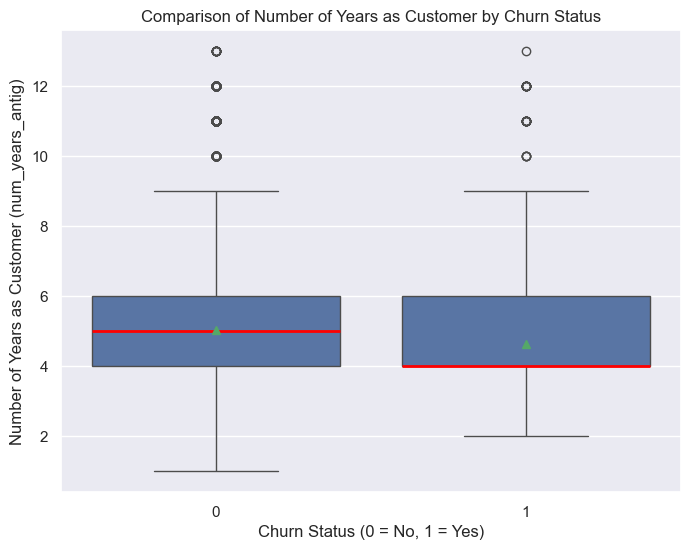

The box plot visually confirms that non-churned customers tend to have a longer median tenure.


In [18]:
plt.figure(figsize=(8, 6)) 
sns.boxplot(x='churn', y='num_years_antig', data=client_df, showmeans=True, 
            medianprops={'color':'red', 'linewidth': 2})  # Customize median line
plt.title('Comparison of Number of Years as Customer by Churn Status')
plt.xlabel('Churn Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Years as Customer (num_years_antig)')
plt.show()

# --- Direction Interpretation (from medians) ---
if median_antig_churn_0 > median_antig_churn_1:
    print("The box plot visually confirms that non-churned customers tend to have a longer median tenure.")
else:
    print("The box plot visually confirms that churned customers tend to have a shorter median tenure.")

### 4.4.3. <a id='toc4_4_3_'></a>[Quantifying the Impact of Customer Tenure on Churn Probability: A Logistic Regression Analysis](#toc0_)

Now that we have confirmed the direction of the relationship, we proceed with quantifying the magnitude of the impact. 
To do this, we employed a logistic regression model to estimate the relationship between customer tenure (num_years_antig) and the probability of churn, while controlling for other factors.

The regression equation is:

$$
\log(\text{odds of churn}) = \beta_0 + \beta_1 \times \text{num\_years\_antig}
$$

Here, $\beta_0$ represents the intercept, and $\beta_1$ is the coefficient for `num_years_antig`. The coefficient $\beta_1$ tells us how much the log odds of churn change for each additional year of customer tenure.

To make the impact of tenure more interpretable, we calculated the odds ratio, which is derived from the exponentiation of $\beta_1$:

$$
\text{odds ratio} = \exp(\beta_1)
$$

The odds ratio reveals the proportional change in the odds of churn for each additional year of customer tenure. A value less than 1 suggests that as tenure increases, the odds of churn decrease, highlighting the protective effect of longer customer relationships against churn.

In [59]:
# Prepare the data
X = client_df[['num_years_antig']]
y = client_df['churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model's performance
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Interpret the coefficients
print(f"Coefficient for num_years_antig: {model.coef_[0][0]:.4f}")

odds_ratio = np.exp(model.coef_[0][0])
print(f"Odds Ratio for num_years_antig: {odds_ratio:.4f}")

Accuracy: 0.8988
ROC-AUC: 0.5760
Coefficient for num_years_antig: -0.1791
Odds Ratio for num_years_antig: 0.8361


The model's high accuracy (89.88%) indicates it is reliable for making inferences about customer churn. This provides confidence in its ability to capture the relationship between customer tenure and churn.

**Key Findings**
- The negative coefficient for tenure suggests that as the number of years a customer has been with the company increases, the likelihood of churn decreases. 
- Specifically, the odds ratio of 0.8361 indicates that for each additional year of tenure, the odds of churn decrease by 16.39%. 
- This means that customers who stay with the company for longer periods are significantly less likely to churn compared to newer customers.

In [72]:
client_df.shape

(14171, 27)

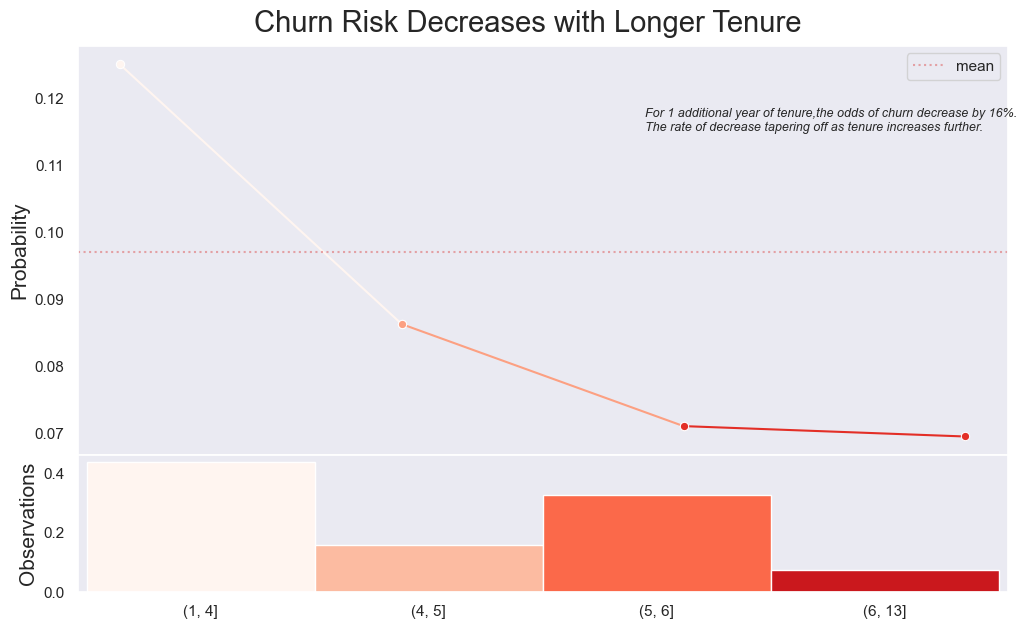

In [19]:
plot_prob_progression(client_df['num_years_antig'].dropna().reset_index(drop=True),
                      client_df['churn'].dropna().reset_index(drop=True),
                      x_intervals=4, use_quartiles=True,  mean_line=True,
                      title='Churn Risk Decreases with Longer Tenure',
                      text="For 1 additional year of tenure,the odds of churn decrease by 16%.\nThe rate of decrease tapering off as tenure increases further.")
     

# 5. <a id='toc5_'></a>[Identifying Key Customer Segments](#toc0_)

Having established a connection between churn, net margin on power subscriptions, and customer tenure, we can leverage these insights to pinpoint specific customer segments requiring further attention. A contour map will provide a visual representation of this relationship, highlighting key areas of interest

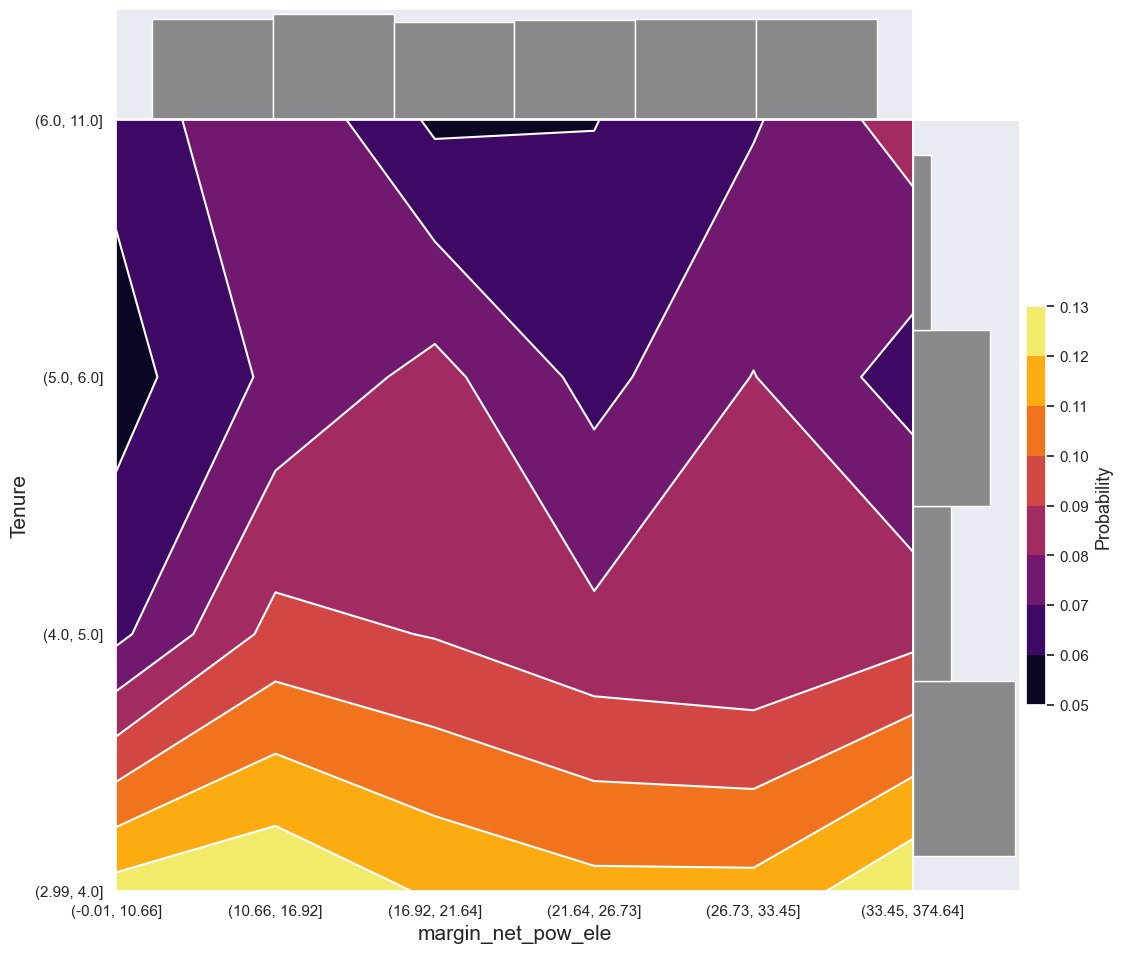

In [20]:
plot_prob_contour_map(client_df.margin_net_pow_ele, client_df_processed.num_years_antig, client_df_processed.churn, use_quartiles=True, x_intervals=6, y_intervals=4, xlabel='margin_net_pow_ele', ylabel='Tenure')

Analysis of the customer contour map above revealed two distinct customer segments that have the highest risk of churn:
- **Segment 1**: Low Tenure, Low Margin
    - This segment, occupying the lower left quadrant of the contour map, represents customers with both a tenure of less than 4 years and a net margin on their power subscription below $17.
- **Segment 2**: Low Tenure, High Margin
    -  Located in the lower right quadrant of the contour map, this segment consists of customers who, despite a tenure of less than 4 years, demonstrate a net margin on their power subscription exceeding $34

# 6. <a id='toc6_'></a>[Analyzing Financial and Strategic Impact of Reducing Customer Churn](#toc0_)

In [85]:
# Calculate the number of customers
num_customers = len(client_df)
print(f"Number of Customers: {num_customers}")

# Calculate average annual revenue per customer
avg_annual_revenue = client_df['net_margin'].mean()
print(f"Average Annual Revenue per Customer: {avg_annual_revenue:.2f}")

# Calculate total annual revenue
total_annual_revenue = client_df['net_margin'].sum()
print(f"Total Annual Revenue: {total_annual_revenue:.2f}")

# Calculate average customer lifespan
avg_customer_lifespan = client_df['num_years_antig'].mean()
print(f"Average Customer Lifespan: {avg_customer_lifespan:.2f}")

# Calculate lifetime value
lifetime_value = avg_annual_revenue * avg_customer_lifespan
print(f"Average Lifetime Value per Customer: {lifetime_value:.2f}")



Number of Customers: 14171
Average Annual Revenue per Customer: 172.91
Total Annual Revenue: 2450316.54
Average Customer Lifespan: 5.01
Average Lifetime Value per Customer: 865.53


**Key Metrics**:
- Number of Customers: 14,171
- Average Annual Revenue per Customer: $172.91
- Total Annual Revenue: $2,450,316.54
- Average Customer Lifespan: 5 years
- Average Lifetime Value per Customer: $865.53

**Assumptions**:
- Profit Margin: 20%
- Customer Acquisition Cost: 1.5 times the annual revenue per customer

### 6.1.1. <a id='toc6_1_1_'></a>[Financial Implications](#toc0_)

a) **Revenue Impact**  
For each additional year a customer is retained, the expected revenue increase per customer is:
- **Expected additional revenue per year retained**:  
  $172.91 * 0.1639 = $28.34 per customer per year

b) **Lifetime Value Increase**  
Based on the average customer lifespan of 5 years, the increase in lifetime value due to extended retention is:
- **Lifetime value increase**:  
  $28.34 * 5.01 = $141.98 per customer

c) **Profit Impact**  
With a 20% profit margin, the additional profit generated from retention is:
- **Annual profit increase**:  
  $28.34 * 0.20 = $5.67 per customer per year  
- **Total profit increase over average lifespan**:  
  $5.67 * 5.01 = $28.41 additional profit per customer

d) **Return on Retention Investment (ROI)**  
- **Estimated customer acquisition cost**:  
  $172.91 * 1.5 = $259.37*per customer
- **Investment in retention efforts**:  
  If 25% of the acquisition cost is reinvested in retention efforts per customer, it amounts to $64.84
- **ROI over average lifespan**:  
  ROI = ($141.98 - $64.84) / $64.84 = 119.0%

### 6.1.2. <a id='toc6_1_2_'></a>[Strategic Implications](#toc0_)

a) **Early Customer Focus**  
By focusing on reducing first-year churn by 10%, the financial benefits can be significant:
- **Additional retained customers**:  
  14,171 * 0.10 = 1,417 customers
- **Financial benefit**:  
  1,417 * $141.98 = $201,185.66 in additional lifetime value

b) **Loyalty Program Investment**  
Investing $20 per customer annually over the average lifespan yields:
- **Total cost over average lifespan**:  
  $20 * 5.01 = $100.20 per customer
- **Expected return**:  
  $141.98 per customer
- **Net benefit**:  
  $141.98 - $100.20 = $41.78 per customer
- **Company-wide net benefit**:  
  14,171 * $41.78 = $592,064.38 over the average customer lifespan

### 6.1.3. <a id='toc6_1_3_'></a>[Long-Term Business Impact](#toc0_)

Reducing the overall churn rate by 5% through tenure-focused strategies leads to:
- **Additional retained customers**:  
  14,171 * 0.05 = 709 customers
- **Additional lifetime value**:  
  709 * $141.98 = $100,664.82
- **Additional profit**:  
  $100,664.82 * 0.20 = $20,132.96

### 6.1.4. <a id='toc6_1_4_'></a>[Total Company-Wide Impact](#toc0_)

- **Current annual revenue**:  
  $2,450,316.54
- **Potential additional annual revenue from a 5% churn reduction**:  
  709 * $172.91 = $122,593.19
- **Percentage increase in annual revenue**: 5%

These findings demonstrate that targeted retention strategies focusing on reducing churn, particularly in the early stages of customer relationships, can substantially increase both revenue and profitability. Investing in loyalty programs and other retention efforts not only improves customer lifetime value but also delivers a strong return on investment, reinforcing the business's long-term sustainability and growth.